In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from ucimlrepo import fetch_ucirepo
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer


from trabalho_ic_aplicada.models import aux
from trabalho_ic_aplicada.models import reg_mlp
from trabalho_ic_aplicada.models.reg_perceptron import treinar_perceptron_reg, prever_perceptron_reg

In [9]:
# fetch dataset
real_estate_valuation = fetch_ucirepo(id=477)

features = real_estate_valuation.variables.iloc[1:, 0].values
# data (as pandas dataframes)
X = real_estate_valuation.data.features.to_numpy()

# Removendo a primeira coluna (X1 transaction date) que não é um atributo relevante, segundo analise.
X = X[:, 1:]

y = real_estate_valuation.data.targets.to_numpy().ravel()


k_fold = aux.validacao_cruzada_kfold(X,y,k=10)


Erro Quadrático Médio (EQM): 242.9175 ± 78.5573
Raiz do Erro Quadrático Médio (REQM): 15.3854 ± 2.4915
Hit rate 20%: 0.2899 ± 0.0649
Hit rate 10%: 0.1284 ± 0.0562

--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.4827 ± 0.1034
Correlação Média (Teste): 0.4838 ± 0.1539
Coeficiente de Determinação (R²): -0.3646 ± 0.2666

--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.9669, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.9660, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


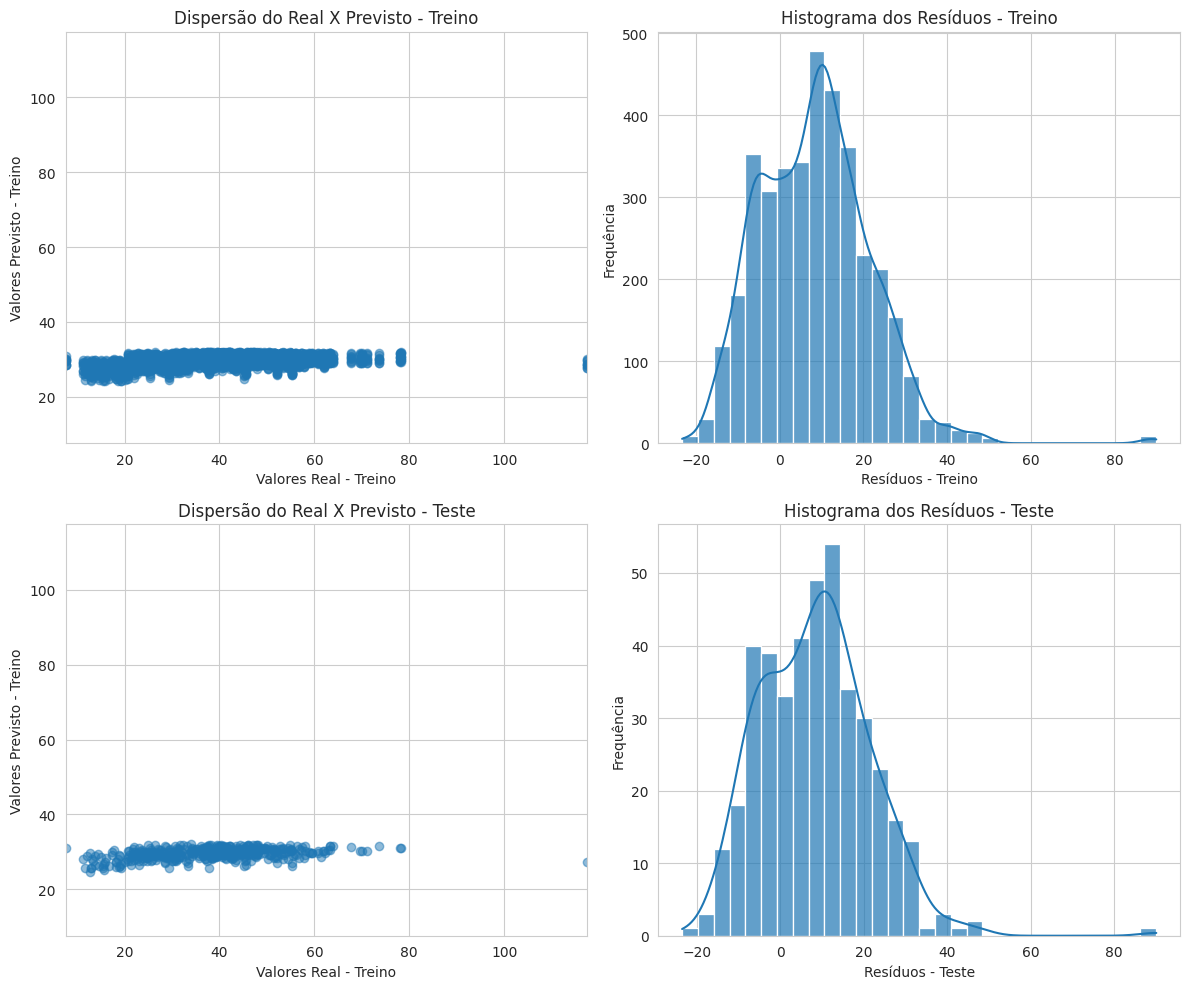

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def inicializar_pesos(n_features, n_outputs, n_hidden):
    """
    Inicializa as matrizes de peso para a MLP.
    """
    W = np.random.rand(n_hidden, n_features + 1) - 0.5
    M = np.random.rand(n_outputs, n_hidden + 1) - 0.5
    return W, M

def treinar_mlp_regressao(X_train, y_train, n_hidden, epochs, eta_i, eta_f, versbose=False):
    """
    Treina a MLP para um problema de REGRESSÃO.
    """
    n_samples, n_features = X_train.shape
    # Para regressão, a saída é geralmente uma única coluna
    n_outputs = y_train.shape[1] if y_train.ndim > 1 else 1

    W, M = inicializar_pesos(n_features, n_outputs, n_hidden)

    mse_history = []
    total_iterations = epochs * n_samples

    for epoch in range(epochs):
        permutation = np.random.permutation(n_samples)
        X_train_shuffled = X_train[permutation]
        y_train_shuffled = y_train[permutation]

        epoch_squared_error = 0.0

        for i in range(n_samples):
            x_sample = X_train_shuffled[i]
            y_target = y_train_shuffled[i]

            # --- Forward Pass ---
            X_b = np.insert(x_sample, 0, -1)
            Ui = W @ X_b
            Yi = np.tanh(Ui) # Não-linearidade na camada oculta
            Y_b = np.insert(Yi, 0, -1)
            Uk = M @ Y_b
            Ok = Uk # MUDANÇA 1: Ativação LINEAR na camada de saída

            # --- Cálculo do Erro ---
            Ek = y_target - Ok
            epoch_squared_error += 0.5 * np.sum(Ek**2)

            # --- Backward Pass ---
            # MUDANÇA 2: A derivada da função linear é 1
            DDk = Ek # O gradiente local da saída é o próprio erro

            Di = 0.5 * (1 - Yi**2)
            DDi = Di * (M[:, 1:].T @ DDk)

            # --- Atualização dos Pesos ---
            current_iteration = epoch * n_samples + i
            eta = eta_i - ((eta_i - eta_f) / total_iterations) * current_iteration

            DDk_col = DDk.reshape(-1, 1)
            Y_b_row = Y_b.reshape(1, -1)
            DDi_col = DDi.reshape(-1, 1)
            X_b_row = X_b.reshape(1, -1)

            M += eta * (DDk_col @ Y_b_row)
            W += eta * (DDi_col @ X_b_row)

        mse_history.append(epoch_squared_error / n_samples)
        if versbose: print(f"Época: {epoch + 1}/{epochs}, MSE: {mse_history[-1]:.6f}")

    return W, M, mse_history

def prever_mlp_regressao(X_test, W, M):
    """
    Realiza a predição de regressão usando pesos já treinados.
    """
    n_samples = X_test.shape[0]
    predictions = []

    for i in range(n_samples):
        x_sample = X_test[i]

        # Forward Pass
        X_b = np.insert(x_sample, 0, -1)
        Ui = W @ X_b
        Yi = np.tanh(Ui)
        Y_b = np.insert(Yi, 0, -1)
        Uk = M @ Y_b
        Ok = Uk # Saída linear
        predictions.append(Ok)

    return np.array(predictions).flatten()

# PARÂMETROS
N_HIDDEN_NEURONS = 10
LEARNING_RATE = 0.00001 # Taxas de aprendizado menores são comuns em regressão
EPOCHS = 50

# CARREGAMENTO DOS DADOS (Exemplo: Dataset de Imóveis)
# try:
#     # Tenta carregar o dataset de imóveis do trabalho TC1
#     # O arquivo Excel original foi convertido para CSV para facilitar.
#     df = pd.read_csv('real_estate.csv')
#     # Removendo colunas não-preditivas
#     df = df.drop(columns=['No', 'X1 transaction date'])
#
#     dados = df.iloc[:, :-1].values
#     alvos = df.iloc[:, -1].values
#
# except FileNotFoundError:
#     print("Arquivo 'real_estate.csv' não encontrado. Gerando dados sintéticos para demonstração.")
#     # Gerando uma função não-linear simples: y = sin(x1) + x2^2 + ruído
#     n_pontos = 400
#     dados = np.random.rand(n_pontos, 2) * 5
#     alvos = np.sin(dados[:, 0]) + dados[:, 1]**0.5 + np.random.randn(n_pontos) * 0.1

# # O usuário pediu para não se preocupar com normalização e divisão treino/teste.
# X_treino = dados
# # Garante que 'alvos' seja um vetor coluna
# y_treino = alvos.reshape(-1, 1)

# print(f"Dimensões dos dados de entrada: {X_treino.shape}")
# print(f"Dimensões dos alvos: {y_treino.shape}")
# print("-" * 30)

# Listas para métricas
eqms_iqr = []
reqms_iqr = []
r_quadrados_iqr = []
hit_rates_20_iqr = []
hit_rates_10_iqr = []

# Listas para resíduos e correlações
correlacoes_treino = []
correlacoes_teste = []

# Listas para análise final
y_trains = []
y_train_preds = []
y_tests = []
y_test_preds = []

# MSEs
historicos_mses = []

# Loop de validação cruzada
for k in range(len(k_fold)):
    # Dados de treino
    X_train_k = X[k_fold[k][0], :]
    y_train_k = y[k_fold[k][0]]

        # Normalização
    scaler = QuantileTransformer(n_quantiles=X_train_k.shape[0], output_distribution='uniform')
    X_train_k = scaler.fit_transform(X_train_k)

    # TREINAMENTO DO MODELO
    W_treinado, M_treinado, historico_mse = treinar_mlp_regressao(
        X_train_k, y_train_k,
        n_hidden=N_HIDDEN_NEURONS,
        epochs=EPOCHS,
        eta_i=LEARNING_RATE,
        eta_f=LEARNING_RATE
    )

    historicos_mses.append(historico_mse)

    # PREDIÇÃO E AVALIAÇÃO (MUDANÇA 3: Novas Métricas)
    y_pred_train = prever_mlp_regressao(X_train_k, W_treinado, M_treinado)
    corr_treino = np.corrcoef(y_train_k.flatten(), y_pred_train.flatten())[0, 1]
    correlacoes_treino.append(corr_treino)


    X_test_k = X[k_fold[k][1], :]
    y_test_k = y[k_fold[k][1]]
    X_test_k = scaler.transform(X_test_k)

    # Previsão teste
    y_pred_test = prever_mlp_regressao(X_test_k, W_treinado, M_treinado)
    corr_teste = np.corrcoef(y_test_k.flatten(), y_pred_test.flatten())[0, 1]
    correlacoes_teste.append(corr_teste)


    # Armazenar para análises finais
    y_trains.extend(y_train_k)
    y_train_preds.extend(y_pred_train)
    y_tests.extend(y_test_k)
    y_test_preds.extend(y_pred_test)

    # Cálculo de métricas e resíduos
    eqm, reqm, r2, hit20, hit10, _ = aux.calcular_metricas(y_test_k, y_pred_test, aux)
    eqms_iqr.append(eqm)
    reqms_iqr.append(reqm)
    r_quadrados_iqr.append(r2)
    hit_rates_20_iqr.append(hit20)
    hit_rates_10_iqr.append(hit10)

# Converter para array
y_trains = np.array(y_trains)
y_train_preds = np.array(y_train_preds)
y_tests = np.array(y_tests)
y_test_preds = np.array(y_test_preds)

# Imprimir métricas
aux.imprimir_metricas(eqms_iqr, reqms_iqr, r_quadrados_iqr, hit_rates_20_iqr, hit_rates_10_iqr)

# Correlações
aux.imprimir_correlacoes(correlacoes_treino, correlacoes_teste, r_quadrados_iqr)

# Análise dos resíduos + gráfico + shapiro
aux.analisar_residuos(
    y_trains, y_train_preds,
    y_tests, y_test_preds,
    aux,
    titulo='Regressão MLP (MLP Regression 1H)'
)


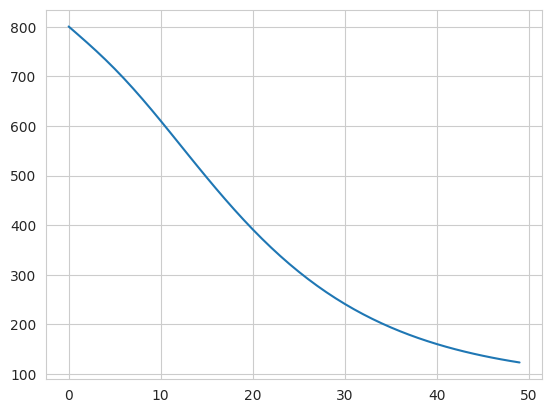

In [11]:
plt.plot(np.mean(historicos_mses, axis=0))

Network architecture: [5, 5, 1]
Hidden activation: tanh
Output activation: linear
--------------------------------------------------


Epoch 100/100 | MSE: 29.046454: 100%|██████████| 100/100 [00:02<00:00, 41.42it/s]
Epoch 100/100 | MSE: 31.167434: 100%|██████████| 100/100 [00:02<00:00, 41.43it/s]
Epoch 100/100 | MSE: 32.718231: 100%|██████████| 100/100 [00:02<00:00, 41.62it/s]
Epoch 100/100 | MSE: 31.173612: 100%|██████████| 100/100 [00:02<00:00, 41.64it/s]
Epoch 100/100 | MSE: 30.503569: 100%|██████████| 100/100 [00:02<00:00, 41.65it/s]
Epoch 100/100 | MSE: 24.679000: 100%|██████████| 100/100 [00:02<00:00, 41.68it/s]
Epoch 100/100 | MSE: 31.356733: 100%|██████████| 100/100 [00:02<00:00, 41.63it/s]
Epoch 100/100 | MSE: 32.443338: 100%|██████████| 100/100 [00:02<00:00, 41.53it/s]
Epoch 100/100 | MSE: 30.031642: 100%|██████████| 100/100 [00:02<00:00, 41.64it/s]
Epoch 100/100 | MSE: 31.228256: 100%|██████████| 100/100 [00:02<00:00, 42.11it/s]


Erro Quadrático Médio (EQM): 64.9139 ± 41.1398
Raiz do Erro Quadrático Médio (REQM): 7.7543 ± 2.1876
Hit rate 20%: 0.7749 ± 0.0525
Hit rate 10%: 0.4786 ± 0.0555

--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.8258 ± 0.0102
Correlação Média (Teste): 0.8249 ± 0.0740
Coeficiente de Determinação (R²): 0.6568 ± 0.1119

--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.8318, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.8378, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


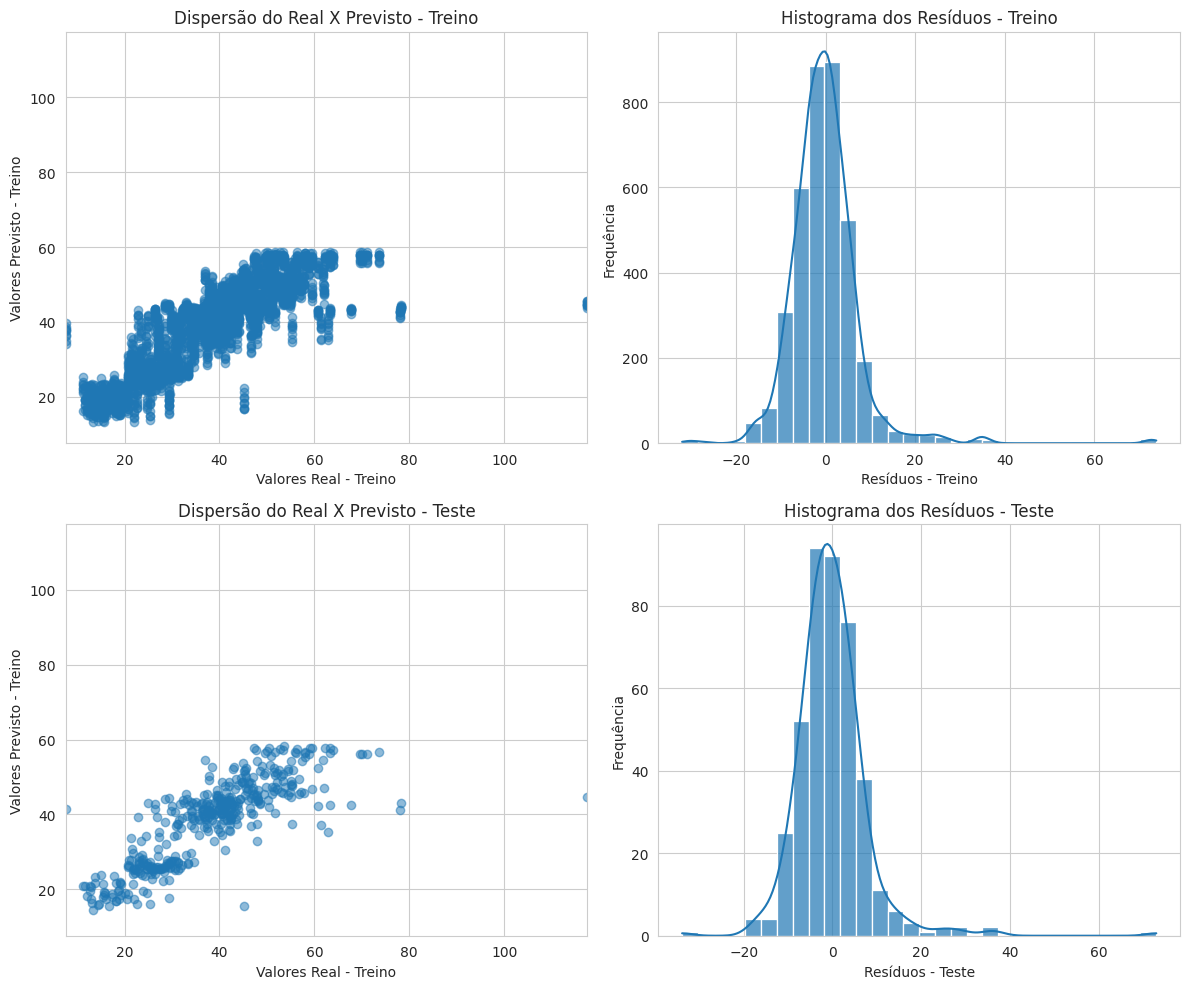

In [12]:
#Example parameters
LAYER_SIZES = [5, 5, 1]  # Input features will be auto-detected
HIDDEN_ACTIVATION = 'tanh'    # Options: 'tanh', 'sigmoid', 'relu', 'leaky_relu', 'linear'
OUTPUT_ACTIVATION = 'linear'  # Usually 'linear' for regression
LEARNING_RATE_INITIAL = 0.001
LEARNING_RATE_FINAL = 0.001
EPOCHS = 100


# Listas para métricas
eqms_iqr = []
reqms_iqr = []
r_quadrados_iqr = []
hit_rates_20_iqr = []
hit_rates_10_iqr = []

# Listas para resíduos e correlações
correlacoes_treino = []
correlacoes_teste = []

# Listas para análise final
y_trains = []
y_train_preds = []
y_tests = []
y_test_preds = []

# print(f"Data shape: X={X_demo.shape}, y={y_demo.shape}")
print(f"Network architecture: {LAYER_SIZES}")
print(f"Hidden activation: {HIDDEN_ACTIVATION}")
print(f"Output activation: {OUTPUT_ACTIVATION}")
print("-" * 50)

# Loop de validação cruzada
for k in range(len(k_fold)):
    # Dados de treino
    X_train_k = X[k_fold[k][0], :]
    y_train_k = y[k_fold[k][0]]

    # Normalização
    scaler = QuantileTransformer(n_quantiles=X_train_k.shape[0], output_distribution='uniform')
    X_train_k = scaler.fit_transform(X_train_k)

    # Train the network
    W, curva_loss = reg_mlp.train_mlp_regression(
        X_train_k, y_train_k,
        layer_sizes=LAYER_SIZES,
        epochs=EPOCHS,
        eta_i=LEARNING_RATE_INITIAL,
        eta_f=LEARNING_RATE_FINAL,
        hidden_activation=HIDDEN_ACTIVATION,
        output_activation=OUTPUT_ACTIVATION,
        verbose=True
    )

    # Make predictions
    y_pred_train = reg_mlp.predict_mlp_regression(X_train_k, W,
                                            HIDDEN_ACTIVATION, OUTPUT_ACTIVATION)

    corr_treino = np.corrcoef(y_train_k.flatten(), y_pred_train.flatten())[0, 1]
    correlacoes_treino.append(corr_treino)

    X_test_k = X[k_fold[k][1], :]
    y_test_k = y[k_fold[k][1]]
    X_test_k = scaler.transform(X_test_k)

    y_pred_test = reg_mlp.predict_mlp_regression(X_test_k, W,
                                            HIDDEN_ACTIVATION, OUTPUT_ACTIVATION)
    corr_teste = np.corrcoef(y_test_k.flatten(), y_pred_test.flatten())[0, 1]
    correlacoes_teste.append(corr_teste)

    # Armazenar para análises finais
    y_trains.extend(y_train_k)
    y_train_preds.extend(y_pred_train)
    y_tests.extend(y_test_k)
    y_test_preds.extend(y_pred_test)

    # Cálculo de métricas e resíduos
    eqm, reqm, r2, hit20, hit10, _ = aux.calcular_metricas(y_test_k, y_pred_test, aux)
    eqms_iqr.append(eqm)
    reqms_iqr.append(reqm)
    r_quadrados_iqr.append(r2)
    hit_rates_20_iqr.append(hit20)
    hit_rates_10_iqr.append(hit10)

# Converter para array
y_trains = np.array(y_trains)
y_train_preds = np.array(y_train_preds)
y_tests = np.array(y_tests)
y_test_preds = np.array(y_test_preds)

# Imprimir métricas
aux.imprimir_metricas(eqms_iqr, reqms_iqr, r_quadrados_iqr, hit_rates_20_iqr, hit_rates_10_iqr)

# Correlações
aux.imprimir_correlacoes(correlacoes_treino, correlacoes_teste, r_quadrados_iqr)

# Análise dos resíduos + gráfico + shapiro
aux.analisar_residuos(
    y_trains, y_train_preds,
    y_tests, y_test_preds,
    aux,
    titulo='Regressão MLP (MLP Regression 1H)'
)

### Percetron Logistico

Network architecture: [5, 1]
Hidden activation: linear
Output activation: sigmoid
--------------------------------------------------


Epoch 100/100 | MSE: 0.007600: 100%|██████████| 100/100 [00:01<00:00, 57.93it/s]
Epoch 100/100 | MSE: 0.008766: 100%|██████████| 100/100 [00:01<00:00, 58.03it/s]
Epoch 100/100 | MSE: 0.004908: 100%|██████████| 100/100 [00:01<00:00, 58.17it/s]
Epoch 100/100 | MSE: 0.012634: 100%|██████████| 100/100 [00:01<00:00, 58.23it/s]
Epoch 100/100 | MSE: 0.005694: 100%|██████████| 100/100 [00:01<00:00, 58.11it/s]
Epoch 100/100 | MSE: 0.009662: 100%|██████████| 100/100 [00:01<00:00, 57.56it/s]
Epoch 100/100 | MSE: 0.004592: 100%|██████████| 100/100 [00:01<00:00, 58.54it/s]
Epoch 100/100 | MSE: 0.010274: 100%|██████████| 100/100 [00:01<00:00, 58.13it/s]
Epoch 100/100 | MSE: 0.006027: 100%|██████████| 100/100 [00:01<00:00, 58.55it/s]
Epoch 100/100 | MSE: 0.005549: 100%|██████████| 100/100 [00:01<00:00, 59.08it/s]


Erro Quadrático Médio (EQM): 163.0490 ± 60.2861
Raiz do Erro Quadrático Médio (REQM): 12.5292 ± 2.4635
Hit rate 20%: 0.4954 ± 0.1122
Hit rate 10%: 0.2797 ± 0.0592

--- Coeficientes de Correlação (Real vs. Previsto) ---
Correlação Média (Treino): 0.3410 ± 0.3846
Correlação Média (Teste): 0.3849 ± 0.3662
Coeficiente de Determinação (R²): 0.0746 ± 0.3379

--- Análise de Gaussianidade dos Resíduos ---
Shapiro-Wilk (Treino): Estatística=0.9743, p-valor=0.0000
Shapiro-Wilk (Teste): Estatística=0.9588, p-valor=0.0000
Resíduos de treino NÃO seguem distribuição normal.


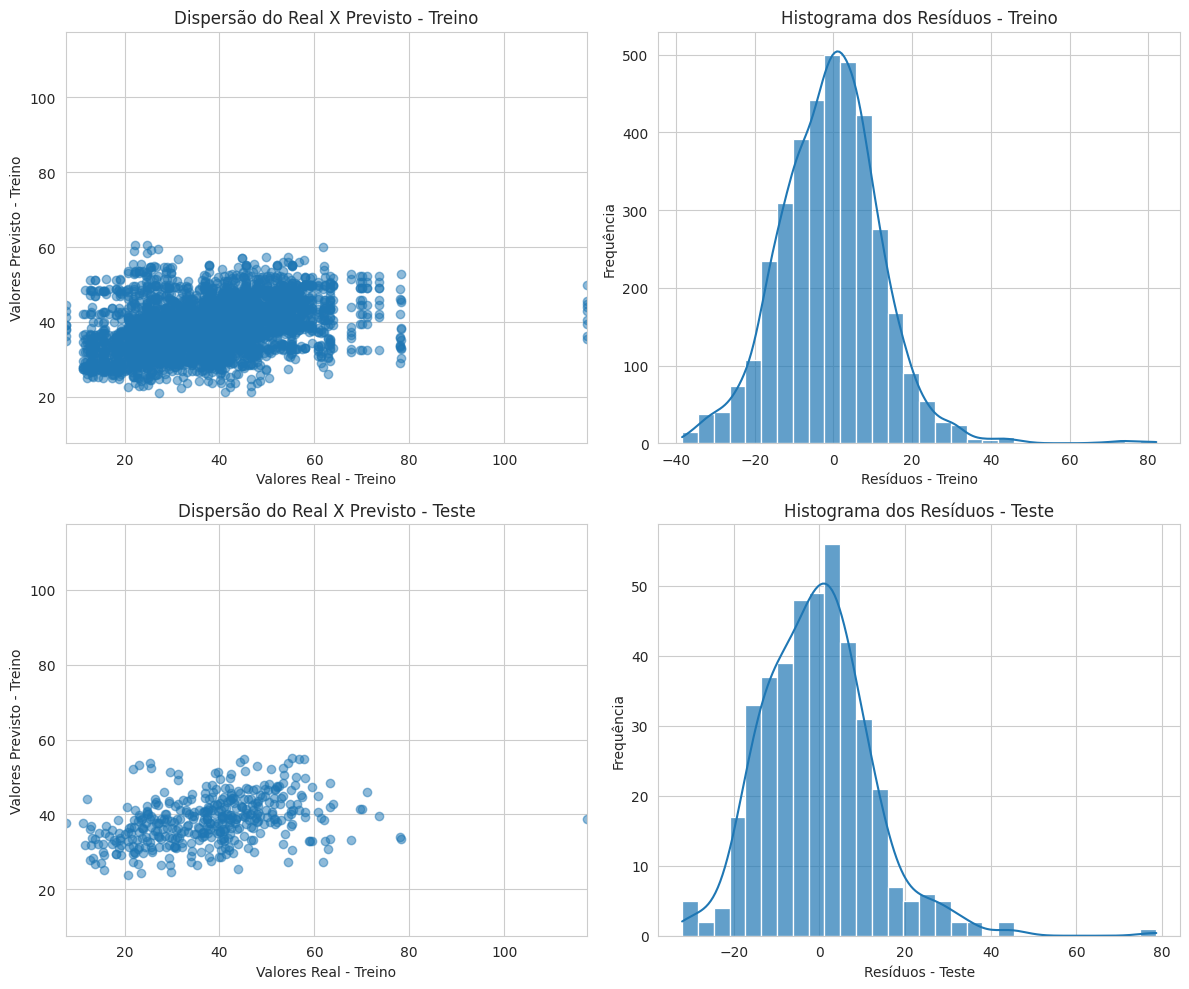

In [13]:
#Example parameters
LAYER_SIZES = [5, 1]  # Input features will be auto-detected
HIDDEN_ACTIVATION = 'linear'  # Ignored when no hidden layer
OUTPUT_ACTIVATION = 'sigmoid'  # Usually 'linear' for regression
LEARNING_RATE_INITIAL = 0.001
LEARNING_RATE_FINAL = 0.001
EPOCHS = 100


# Listas para métricas
eqms_iqr = []
reqms_iqr = []
r_quadrados_iqr = []
hit_rates_20_iqr = []
hit_rates_10_iqr = []

# Listas para resíduos e correlações
correlacoes_treino = []
correlacoes_teste = []

# Listas para análise final
y_trains = []
y_train_preds = []
y_tests = []
y_test_preds = []

# print(f"Data shape: X={X_demo.shape}, y={y_demo.shape}")
print(f"Network architecture: {LAYER_SIZES}")
print(f"Hidden activation: {HIDDEN_ACTIVATION}")
print(f"Output activation: {OUTPUT_ACTIVATION}")
print("-" * 50)

# Loop de validação cruzada
for k in range(len(k_fold)):
    # Dados de treino
    X_train_k = X[k_fold[k][0], :]
    y_train_k = y[k_fold[k][0]]

    y_min = y_train_k.min()
    y_max = y_train_k.max()
    y_train_norm = (y_train_k - y_min) / (y_max - y_min)

    # Normalização
    scaler = QuantileTransformer(n_quantiles=X_train_k.shape[0], output_distribution='uniform')
    X_train_k = scaler.fit_transform(X_train_k)

    # Train the network
    W, curva_loss = reg_mlp.train_mlp_regression(
        X_train_k, y_train_norm,
        layer_sizes=LAYER_SIZES,
        epochs=EPOCHS,
        eta_i=LEARNING_RATE_INITIAL,
        eta_f=LEARNING_RATE_FINAL,
        hidden_activation=HIDDEN_ACTIVATION,
        output_activation=OUTPUT_ACTIVATION,
        verbose=True
    )

    # Make predictions
    y_pred_train = reg_mlp.predict_mlp_regression(X_train_k, W,
                                            HIDDEN_ACTIVATION, OUTPUT_ACTIVATION)
    y_pred_train = y_pred_train * (y_max - y_min) + y_min

    corr_treino = np.corrcoef(y_train_k.flatten(), y_pred_train.flatten())[0, 1]
    correlacoes_treino.append(corr_treino)

    X_test_k = X[k_fold[k][1], :]
    y_test_k = y[k_fold[k][1]]
    X_test_k = scaler.transform(X_test_k)


    y_pred_test = reg_mlp.predict_mlp_regression(X_test_k, W,
                                            HIDDEN_ACTIVATION, OUTPUT_ACTIVATION)
    y_pred_test = y_pred_test * (y_max - y_min) + y_min

    corr_teste = np.corrcoef(y_test_k.flatten(), y_pred_test.flatten())[0, 1]
    correlacoes_teste.append(corr_teste)

    # Armazenar para análises finais
    y_trains.extend(y_train_k)
    y_train_preds.extend(y_pred_train)
    y_tests.extend(y_test_k)
    y_test_preds.extend(y_pred_test)

    # Cálculo de métricas e resíduos
    eqm, reqm, r2, hit20, hit10, _ = aux.calcular_metricas(y_test_k, y_pred_test, aux)
    eqms_iqr.append(eqm)
    reqms_iqr.append(reqm)
    r_quadrados_iqr.append(r2)
    hit_rates_20_iqr.append(hit20)
    hit_rates_10_iqr.append(hit10)

# Converter para array
y_trains = np.array(y_trains)
y_train_preds = np.array(y_train_preds)
y_tests = np.array(y_tests)
y_test_preds = np.array(y_test_preds)

# Imprimir métricas
aux.imprimir_metricas(eqms_iqr, reqms_iqr, r_quadrados_iqr, hit_rates_20_iqr, hit_rates_10_iqr)

# Correlações
aux.imprimir_correlacoes(correlacoes_treino, correlacoes_teste, r_quadrados_iqr)

# Análise dos resíduos + gráfico + shapiro
aux.analisar_residuos(
    y_trains, y_train_preds,
    y_tests, y_test_preds,
    aux,
    titulo='Regressão MLP (MLP Regression 1H)'
)

Act=relu    HU= 8 Ep= 50 LR=0.001 → R²=0.6347
Act=sigmoid HU= 8 Ep=100 LR=0.05 → R²=0.5982
Act=sigmoid HU= 4 Ep=100 LR=0.001 → R²=0.6617
Act=relu    HU=16 Ep=100 LR=0.01 → R²=0.5316
Act=sigmoid HU=32 Ep=200 LR=0.05 → R²=0.6445
Act=sigmoid HU=32 Ep=100 LR=0.01 → R²=0.6529
Act=sigmoid HU=32 Ep= 50 LR=0.01 → R²=0.6311
Act=sigmoid HU= 8 Ep=200 LR=0.05 → R²=0.6062
Act=relu    HU=32 Ep=100 LR=0.05 → R²=-0.0498
Act=sigmoid HU= 8 Ep=100 LR=0.01 → R²=0.6561
Act=relu    HU= 8 Ep=100 LR=0.05 → R²=-0.0309
Act=relu    HU=32 Ep= 50 LR=0.001 → R²=0.6436
Act=tanh    HU=32 Ep=200 LR=0.001 → R²=0.6696
Act=sigmoid HU= 8 Ep= 50 LR=0.05 → R²=0.6050
Act=relu    HU= 4 Ep=100 LR=0.001 → R²=0.6436
Act=tanh    HU=16 Ep= 50 LR=0.001 → R²=0.6570
Act=sigmoid HU= 4 Ep=100 LR=0.01 → R²=0.6301
Act=relu    HU=32 Ep=200 LR=0.001 → R²=0.6398
Act=relu    HU=16 Ep=200 LR=0.001 → R²=0.6410
Act=sigmoid HU=32 Ep= 50 LR=0.001 → R²=0.6336
Act=sigmoid HU=32 Ep= 50 LR=0.05 → R²=0.6290
Act=tanh    HU=32 Ep= 50 LR=0.01 → R²=0.6163

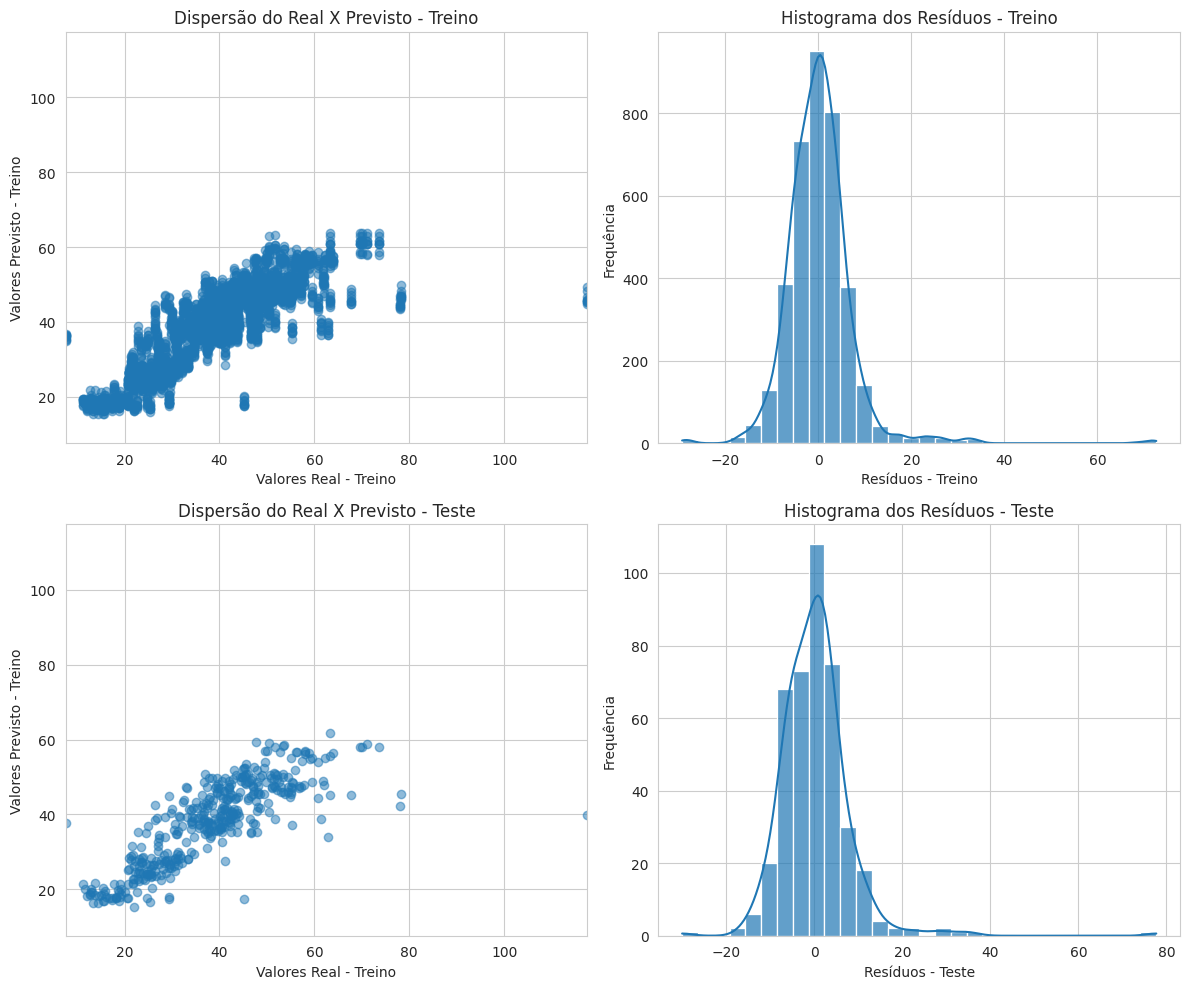

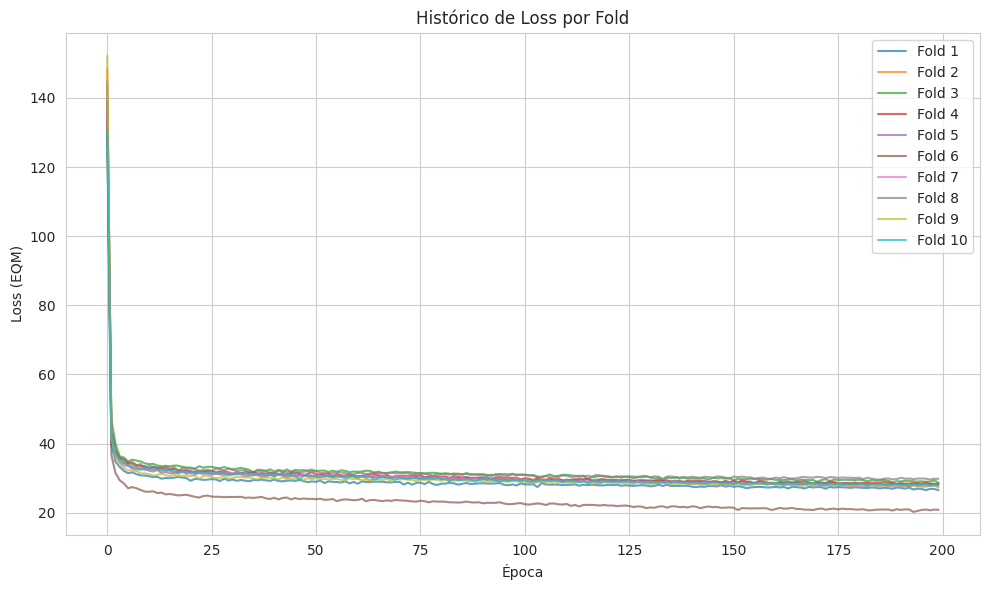

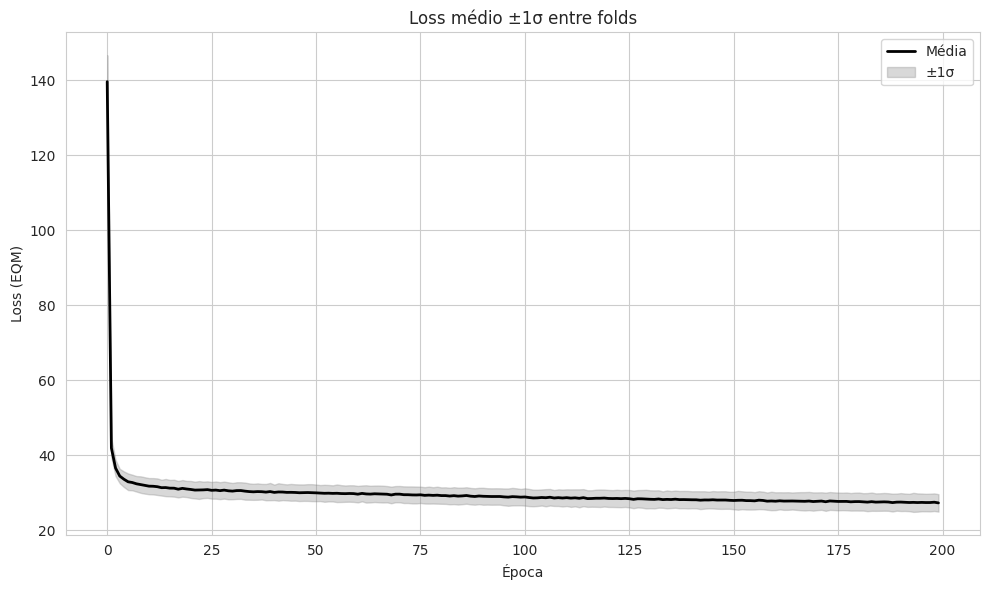

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import QuantileTransformer
from trabalho_ic_aplicada.models import reg_mlp
# import aux  # supondo que aux.calcular_metricas, etc. estejam em aux.py
import random
import itertools

def cross_val_mlp(X, y, k_fold, layer_sizes, activation, epochs, lr):
    """
    Executa CV para um MLP de 1 camada oculta, retorna média de R2 e todas as curvas de loss.
    """
    fold_r2 = []
    fold_losses = []
    for train_idx, test_idx in k_fold:
        X_tr, X_te = X[train_idx], X[test_idx]
        y_tr, y_te = y[train_idx].reshape(-1,1), y[test_idx].reshape(-1,1)
        # Normaliza X
        scaler = QuantileTransformer(n_quantiles=min(X_tr.shape[0],1000), output_distribution='uniform')
        X_tr_n = scaler.fit_transform(X_tr)
        X_te_n = scaler.transform(X_te)
        # Treina
        W, loss_hist = reg_mlp.train_mlp_regression(
            X_tr_n, y_tr,
            layer_sizes=layer_sizes,
            epochs=epochs,
            eta_i=lr, eta_f=lr,
            hidden_activation=activation,
            output_activation='linear',
            verbose=False
        )
        fold_losses.append(loss_hist)
        # Previsão
        y_pred = reg_mlp.predict_mlp_regression(X_te_n, W, activation, 'linear').reshape(-1,1)
        # R2
        _, _, r2, *_ = aux.calcular_metricas(y_te, y_pred, aux)
        fold_r2.append(r2)
    return np.mean(fold_r2), fold_losses

def grid_search(X, y, k_fold, hidden_units, activations, epochs_list, lrs):
    best = {'score': -np.inf}
    for act in activations:
        for hu in hidden_units:
            for ep in epochs_list:
                for lr in lrs:
                    ls = [X.shape[1], hu, 1]
                    mean_r2, _ = cross_val_mlp(X, y, k_fold, ls, act, ep, lr)
                    print(f"Act={act:<7} HU={hu:2d} Ep={ep:3d} LR={lr:.3g} → R²={mean_r2:.4f}")
                    if mean_r2 > best['score']:
                        best.update({
                            'layer_sizes': ls,
                            'activation': act,
                            'epochs': ep,
                            'lr': lr,
                            'score': mean_r2
                        })
    print("\n=== Best config ===")
    print(best)
    return best



def random_search(X, y, k_fold, hidden_units, activations, epochs_list, lrs, n_iter=20, seed=42):
    """
    Executa busca aleatória por hiperparâmetros para o MLP.
    """
    random.seed(seed)
    np.random.seed(seed)

    # Gera todas as combinações possíveis
    all_combinations = list(itertools.product(activations, hidden_units, epochs_list, lrs))
    # Embaralha e pega n combinações aleatórias
    sampled_combinations = random.sample(all_combinations, min(n_iter, len(all_combinations)))

    best = {'score': -np.inf}
    for act, hu, ep, lr in sampled_combinations:
        ls = [X.shape[1], hu, 1]
        mean_r2, _ = cross_val_mlp(X, y, k_fold, ls, act, ep, lr)
        print(f"Act={act:<7} HU={hu:2d} Ep={ep:3d} LR={lr:.3g} → R²={mean_r2:.4f}")
        if mean_r2 > best['score']:
            best.update({
                'layer_sizes': ls,
                'activation': act,
                'epochs': ep,
                'lr': lr,
                'score': mean_r2
            })

    print("\n=== Best config ===")
    print(best)
    return best

def plot_folds_loss(fold_losses):
    # todos os folds
    plt.figure(figsize=(10,6))
    for i, h in enumerate(fold_losses):
        plt.plot(h, label=f'Fold {i+1}', alpha=0.7)
    plt.xlabel("Época"); plt.ylabel("Loss (EQM)")
    plt.title("Histórico de Loss por Fold")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
    # média ± std
    arr = np.array(fold_losses)
    mean = arr.mean(axis=0); std = arr.std(axis=0)
    plt.figure(figsize=(10,6))
    plt.plot(mean, 'k-', lw=2, label='Média')
    plt.fill_between(range(len(mean)), mean-std, mean+std, color='gray', alpha=0.3,
                     label='±1σ')
    plt.xlabel("Época"); plt.ylabel("Loss (EQM)")
    plt.title("Loss médio ±1σ entre folds")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

# 1) Grid search
hidden_units  = [4,8,16,32]
activations   = ['sigmoid','tanh','relu']
epochs_list   = [50,100,200]
learning_rates= [1e-3,1e-2,5e-2]

# 1) Random search
best_cfg = random_search(X, y, k_fold,
                         hidden_units, activations,
                         epochs_list, learning_rates,
                         n_iter=30)  # você pode ajustar n_iter

# best_cfg = grid_search(X, y, k_fold,
#                        hidden_units, activations,
#                        epochs_list, learning_rates)

# 2) Treino final com CV para coletar tudo
ls   = best_cfg['layer_sizes']
act  = best_cfg['activation']
ep   = best_cfg['epochs']
lr   = best_cfg['lr']

all_train_losses = []
y_tr_all, y_trp_all = [], []
y_te_all, y_tep_all   = [], []
cor_tr, cor_te = [], []

for train_idx, test_idx in k_fold:
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx].reshape(-1,1), y[test_idx].reshape(-1,1)
    scaler = QuantileTransformer(n_quantiles=min(X_tr.shape[0],1000), output_distribution='uniform')
    X_tr_n = scaler.fit_transform(X_tr)
    X_te_n = scaler.transform(X_te)

    W, loss_hist = reg_mlp.train_mlp_regression(
        X_tr_n, y_tr, layer_sizes=ls,
        epochs=ep, eta_i=lr, eta_f=lr,
        hidden_activation=act, output_activation='linear',
        verbose=False
    )
    all_train_losses.append(loss_hist)

    y_trp = reg_mlp.predict_mlp_regression(X_tr_n, W, act, 'linear').reshape(-1,1)
    y_tep = reg_mlp.predict_mlp_regression(X_te_n, W, act, 'linear').reshape(-1,1)

    cor_tr.append(np.corrcoef(y_tr.flatten(), y_trp.flatten())[0,1])
    cor_te.append(np.corrcoef(y_te.flatten(), y_tep.flatten())[0,1])

    y_tr_all .extend(y_tr.flatten())
    y_trp_all.extend(y_trp.flatten())
    y_te_all .extend(y_te.flatten())
    y_tep_all.extend(y_tep.flatten())

# 3) Métricas finais
eqms, reqms, r2s, h20, h10, _ = aux.calcular_metricas(
    np.array(y_te_all), np.array(y_tep_all), aux)
aux.imprimir_metricas(eqms, reqms, r2s, h20, h10)
aux.imprimir_correlacoes(cor_tr, cor_te, r2s)
aux.analisar_residuos(
    np.array(y_tr_all), np.array(y_trp_all),
    np.array(y_te_all), np.array(y_tep_all),
    aux, titulo="MLP Final"
)

# 4) Plots de loss
plot_folds_loss(all_train_losses)
